In [1]:
import random
import math
from numbers  import Number
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors as pltcolors
import matplotlib.patches as mpatches
import numpy as np

In [2]:
def simulate_exact(v: Number, p: Number, bounce1: Number, bounce2: Number, Δt: Number, g:Number, hit=False) -> (Number, Number): 
    """Simulates the ball with a specific velocity v and position p. 
    Parameters:
        v: velocity
        p: height
        bounce1: fraction of velocity preserved when it bounces
        bounce2: fraction of velocity preserved when its hit by the bat
        Δt: timestep
        hit: The action. Whether or not to attempt to hit the ball.
    Returns:
        (v, p): new v and p after timestep Δt"""
    new_v, new_p = None, None  # Result
    v0, p0 = v, p              # To avoid changing argument values
    
    if hit and p >= 4: # Hitting the ball changes the velocity
        if v < 0: 
            v0 = min(v, -4)
        else:
            v0 = -bounce2*v - 4
    
    # Free fall
    new_v = g * Δt + v0
    new_p = 0.5 * g * Δt**2 + v0 * Δt + p0
    
    
    if new_p <= 0: # Hitting the ground
        # Need to establish the exact time t it hits the ground:  0 = 0.5 * g * t**2 + v0 * t + p0
        # This type of equation can have two soutions: t  = (-v0 ± sqrt(v0**2 - 2*g*p0))/g
        #     t1 = (-v0 + sqrt(v0**2 - 2*g*p0))/g
        #     t2 = (-v0 - sqrt(v0**2 - 2*g*p0))/g 
        # In this case, t2 is always the solution. 
        # Proof: t must be positive since the impact occured this timestep.
        #        p0 >= 0 and g < 0 therefore -2*g*p0 >= 0
        #        So therefore abs(v0) <= sqrt(v0**2 - 2*g*p0)
        #        And the ball must have a negative velocity v0 < 0 to hit the ground
        #        So that (-v0 - sqrt(v0**2 - 2*g*p0)) < 0
        #        And divided by g which is also negative we have that 
        #        (-v0 - sqrt(v0**2 - 2*g*p0))/g > 0
        

        #print(f"v0 = {v0:.2f}\tp0 = {p0:.2f}\tt1 = {t1:.2f}\tt2 = {t2:.2f}\tnew_p = {new_p:.2f}")
        #print(f"discriminant = v0**2 - 2*g*p0 = {discriminant:.2f}")
        #print(f"t1 = (-v0 + math.sqrt(v0**2 - 2*g*p0))/g = ({-v0:.2f} + {math.sqrt(v0**2 - 2*g*p0):.2f})/{g:.2f} = {t1:.2f}")
        #print(f"t2 = (-v0 - math.sqrt(v0**2 - 2*g*p0))/g = ({-v0:.2f} - {math.sqrt(v0**2 - 2*g*p0):.2f})/{g:.2f} = {t2:.2f}")
        #print()
        t_impact = (-v0 - math.sqrt(v0**2 - 2*g*p0))/g 
        t_remaining = Δt - t_impact       # Time left this timestep after bounce occurs
        
        new_v = g * t_impact + v0         # Gravity pull before bounce
        
        new_v = -bounce1 * new_v          # Bounce
        
        new_v = g * t_remaining + new_v   # Gravity pull after bounce
        new_p = 0.5 * g * t_remaining**2 + new_v * t_remaining + 0  # Jump height after bounce
        if new_p <= 0:           # If it hits the ground twice within the same timestep, 
            new_v, new_p = 0, 0  # simply put the ball to a stop.
    
    return new_v, new_p

## Constraints on q, u values directly

In [3]:
#   Jvl <= u  < Jvu
#   Jpl <= q  < Jpu
#   Ivl + g * t <= u < Ivu + g * t
#   q >= Ipl + Ivl*t + 1/2 * g * t**2
#   Ipu + Ivu*t + 1/2 * g * t**2 > q 
#   Ipl - 1/2 * g * t**2 <= -u*t + q < Ipu - 1/2 * g * t**2

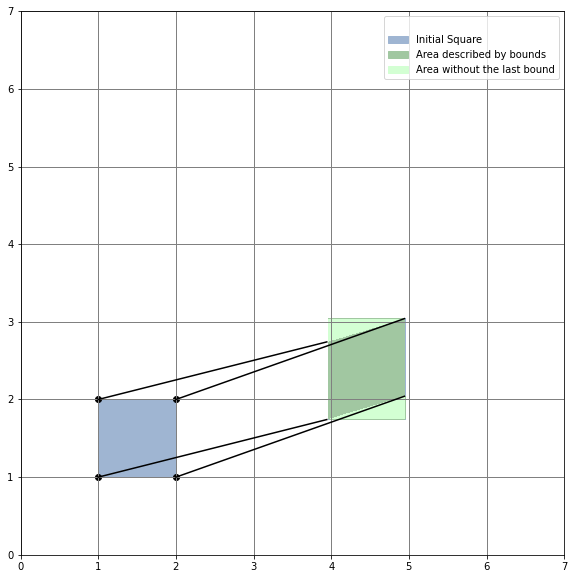

In [4]:
G = 1
g = 9.81
t = 0.3

Ivl = 1
Ipl = 1
Ivu, Ipu = Ivl + G, Ipl + G

granularity_x = 1000
granularity_y = 1000
x_min, x_max = 0, 7
y_min, y_max = 0, 7

scale_x = (x_max - x_min)/granularity_x
scale_y = (y_max - y_min)/granularity_y

grid = np.zeros((granularity_x, granularity_y))


for i, row in enumerate(grid):
    for j, _ in enumerate(row):
        u, q = j*scale_x + x_min, i*scale_y + y_min
        if (    Ivl + g * t <= u < Ivu + g * t and
                q >= Ipl + Ivl*t + 1/2 * g * t**2 and
                Ipu + Ivu*t + 1/2 * g * t**2 > q):
            grid[i][j] = 3
            
        if (    Ivl + g * t <= u < Ivu + g * t and
                q >= Ipl + Ivl*t + 1/2 * g * t**2 and
                Ipu + Ivu*t + 1/2 * g * t**2 > q and
                Ipl - 1/2 * g * t**2 <= -u*t + q < Ipu - 1/2 * g * t**2):
            grid[i][j] = 2
            
        if (    u > Ivl and u < Ivu and 
                q > Ipl and q < Ipu):
            grid[i][j] = 1





# I hate matplotlib

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.gca()

ax.xaxis.set_ticks(np.arange(x_min, x_max+1, G))
ax.yaxis.set_ticks(np.arange(y_min, y_max+1, G))

cmap = pltcolors.ListedColormap(["white", "#9fb5d2", "#a1c7a1", "#d3ffd3"])

image = plt.imshow(grid, origin="lower", extent=(x_min, x_max, y_min, y_max), cmap=cmap)

# Convoluted way to print a legend.
values = np.unique(grid.ravel())
labels = ["", "Initial Square", "Area described by bounds", "Area without the last bound"]
colors = [ image.cmap(image.norm(value)) for value in values]
plt.legend(handles=[mpatches.Patch(color=colors[x], label=f"{labels[x]}") for x in range(len(values))])

plt.grid(color='grey', linestyle='-', linewidth=1, which="both")


for i, j in [(0,0), (1,0), (1,1), (0,1)]:
    example_v, example_p = Ivl + G*i, Ipl + G*j
    example_u, example_q = simulate_exact(example_v, example_p, 0, 0, t, g, False)

    plt.plot([example_v, example_u], [example_p, example_q], color="black")
    plt.scatter([example_v], [example_p], marker="o", color="black")
plt.show()

## Trying to visualise the shape of the projection

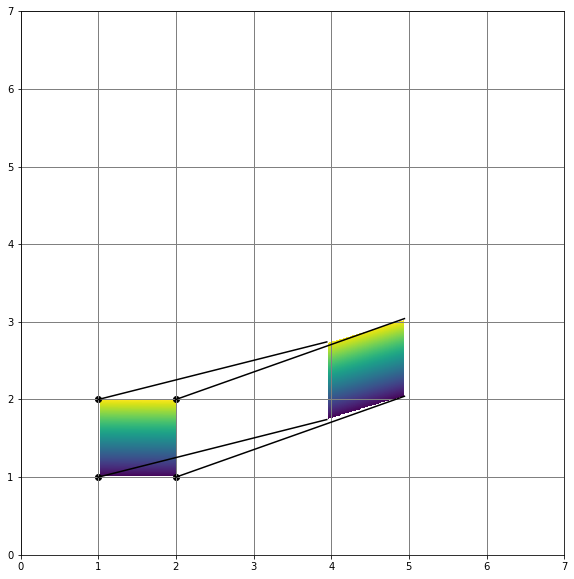

In [39]:
G = 1
g = 9.81
t = 0.3

Ivl = 1
Ipl = 1
Ivu, Ipu = Ivl + G, Ipl + G

granularity_x = 1000
granularity_y = 1000
x_min, x_max = 0, 7
y_min, y_max = 0, 7

scale_x = (x_max - x_min)/granularity_x
scale_y = (y_max - y_min)/granularity_y

grid = np.zeros((granularity_x, granularity_y))
acc=0

for i, row in enumerate(grid):
    for j, _ in enumerate(row):
        grid[i][j] = np.NaN

for i, row in enumerate(grid):
    for j, _ in enumerate(row):
        v, p = j*scale_x + x_min, i*scale_y + y_min
        if (Ivl <= v < Ivu and Ipl <= p < Ipu):
            grid[i][j] = acc
            
            w, q = simulate_exact(v, p, 0.85, 0.90, t, g, False)
            ii, jj = int(q/scale_x - x_min), int(w/scale_y - y_min)
            grid[ii][jj] = acc
            
            acc += 1


# I hate matplotlib

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.gca()

ax.xaxis.set_ticks(np.arange(x_min, x_max+1, G))
ax.yaxis.set_ticks(np.arange(y_min, y_max+1, G))

cmap = plt.get_cmap("viridis")

image = plt.imshow(grid, origin="lower", extent=(x_min, x_max, y_min, y_max), cmap=cmap)

plt.grid(color='grey', linestyle='-', linewidth=1, which="both")


for i, j in [(0,0), (1,0), (1,1), (0,1)]:
    example_v, example_p = Ivl + G*i, Ipl + G*j
    example_u, example_q = simulate_exact(example_v, example_p, 0, 0, t, g, False)

    plt.plot([example_v, example_u], [example_p, example_q], color="black")
    plt.scatter([example_v], [example_p], marker="o", color="black")
plt.show()

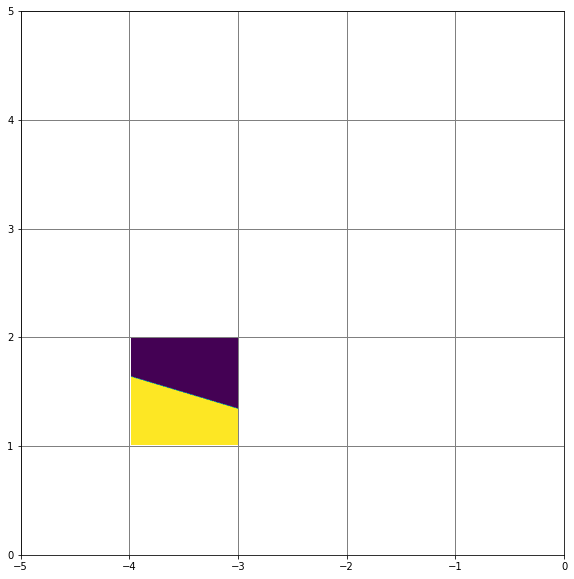

In [23]:
# For when the ball bounce

G = 1
g = -9.81
t = 0.3

Ivl = -4
Ipl = 1
Ivu, Ipu = Ivl + G, Ipl + G

granularity_x = 1000
granularity_y = 1000
x_min, x_max = -5, 0
y_min, y_max = 0, 5

scale_x = (x_max - x_min)/granularity_x
scale_y = (y_max - y_min)/granularity_y

grid = np.zeros((granularity_x, granularity_y))


for i, row in enumerate(grid):
    for j, _ in enumerate(row):
        grid[i][j] = np.NaN

for i, row in enumerate(grid):
    for j, _ in enumerate(row):
        v, p = j*scale_x + x_min, i*scale_y + y_min
        if (Ivl <= v < Ivu and Ipl <= p < Ipu):
            grid[i][j] = 1
            
            w, q = simulate_exact(v, p, 0, 0, t, g, False)
            
            if (w, q) == (0 ,0):
                grid[i][j] = 2


# I hate matplotlib

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.gca()

ax.xaxis.set_ticks(np.arange(x_min, x_max+1, G))
ax.yaxis.set_ticks(np.arange(y_min, y_max+1, G))

cmap = plt.get_cmap("viridis")

image = plt.imshow(grid, origin="lower", extent=(x_min, x_max, y_min, y_max), cmap=cmap)

plt.grid(color='grey', linestyle='-', linewidth=1, which="both")

plt.show()

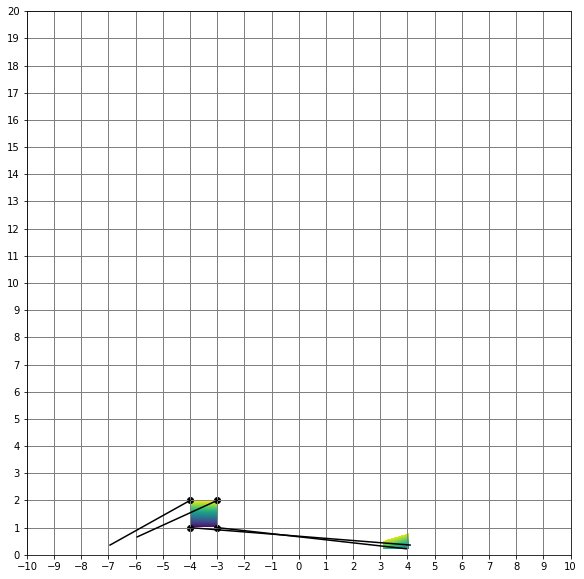

In [36]:
G = 1
g = -9.81
t = 0.3

Ivl = -4
Ipl = 1
Ivu, Ipu = Ivl + G, Ipl + G

granularity_x = 1000
granularity_y = 1000
x_min, x_max = -10, 10
y_min, y_max = 0, 20

scale_x = (x_max - x_min)/granularity_x
scale_y = (y_max - y_min)/granularity_y

grid = np.zeros((granularity_x, granularity_y))
acc=0

for i, row in enumerate(grid):
    for j, _ in enumerate(row):
        grid[i][j] = np.NaN

for i, row in enumerate(grid):
    for j, _ in enumerate(row):
        v, p = j*scale_x + x_min, i*scale_y + y_min
        if (Ivl <= v < Ivu and Ipl <= p < Ipu):
            grid[i][j] = acc
            
            w, q = simulate_exact(v, p, 0.85, 0.90, t, g, False)
            ii, jj = int(q/scale_x - x_min), int(w/scale_y - y_min)
            grid[ii][jj] = acc
            
            acc += 1


# I hate matplotlib

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.gca()

ax.xaxis.set_ticks(np.arange(x_min, x_max+1, G))
ax.yaxis.set_ticks(np.arange(y_min, y_max+1, G))

cmap = plt.get_cmap("viridis")

image = plt.imshow(grid, origin="lower", extent=(x_min, x_max, y_min, y_max), cmap=cmap)

plt.grid(color='grey', linestyle='-', linewidth=1, which="both")

for i, j in [(0,0), (1,0), (1,1), (0,1)]:
    example_v, example_p = Ivl + G*i, Ipl + G*j
    example_u, example_q = simulate_exact(example_v, example_p, 0.85, 0.90, t, g, False)

    plt.plot([example_v, example_u], [example_p, example_q], color="black")
    plt.scatter([example_v], [example_p], marker="o", color="black")
plt.show()

## Constraints on a and b values

In [ ]:
#a*t + t - b > (1/2 * g * t^2) / G - d - 1
#a*t - b <  - (1/2 * g * t^2) / G - d - 1
#b < 2 + (1/2 * g * t^2) / G + c + d
#b > - 1 - (1/2 * g * t^2) / G + c*t + d
#a < c + 1 + (g * t) / G
#a > - 1 + c + (g * t)/G

In [ ]:
c = Ivl / G
d = Ipl / G

In [ ]:
print("a*t + t - b > (1/2 * g * t^2) / G - d - 1")
print(f"a*t + t - b > {(1/2 * g * t**2) / G - d - 1}\n")

print("a*t - b <  - (1/2 * g * t^2) / G - d - 1")
print(f"a*t - b < { - (1/2 * g * t**2) / G - d - 1}\n")

print("b < 2 + (1/2 * g * t^2) / G + c + d")
print(f"b < {2 + (1/2 * g * t**2) / G + c + d}\n")

print("b > - 1 - (1/2 * g * t^2) / G + c*t + d")
print(f"b > { - 1 - (1/2 * g * t**2) / G + c*t + d}\n")

print("a < c + 1 + (g * t) / G")
print(f"a < { c + 1 + (g * t) / G}\n")

print("a > - 1 + c + (g * t)/G")
print(f"a > {- 1 + c + (g * t)/G}\n")